In [2]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 10.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 29.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 30.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 31.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 30.9 MB/s eta 0:0

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_auc_score

In [4]:
# Load the dataset
file_path = 'WMFS_datasets/wmfs_incidents.xlsx'
incidents_df = pd.read_excel(file_path)

In [5]:
# Display the first few rows to understand the structure of the dataset
print(incidents_df.head())
print(incidents_df.info())

            call_time             incident_classification_label  \
0 2009-01-01 00:00:39       False alarm raised with good intent   
1 2009-01-01 00:10:45                            Secondary fire   
2 2009-01-01 00:11:59  False alarm raised with malicious intent   
3 2009-01-01 00:53:02                            Secondary fire   
4 2009-01-01 00:52:13  False alarm raised with malicious intent   

                              incident_profile_label  \
0                                       False Alarms   
1  Secondary Fires that attract a 20 minute-respo...   
2                                       False Alarms   
3  Secondary Fires that attract a 20 minute-respo...   
4                                       False Alarms   

  incident_classification_level1  prl_count  brv_count       EASTINGS  \
0                    FALSE_ALARM          2          0  392062.102010   
1                           FIRE          1          0  405643.149442   
2                    FALSE_ALARM         

In [6]:
# Extract relevant columns
relevant_columns = [
    'call_time', 
    'incident_classification_level1', 
    'EASTINGS', 
    'NORTHINGS'
]

# Create a new DataFrame with only the relevant columns
incidents_df = incidents_df[relevant_columns]

# Display the first few rows of the extracted DataFrame
print(incidents_df.head())

            call_time incident_classification_level1       EASTINGS  \
0 2009-01-01 00:00:39                    FALSE_ALARM  392062.102010   
1 2009-01-01 00:10:45                           FIRE  405643.149442   
2 2009-01-01 00:11:59                    FALSE_ALARM  410260.244387   
3 2009-01-01 00:53:02                           FIRE  396779.250331   
4 2009-01-01 00:52:13                    FALSE_ALARM  410667.961350   

       NORTHINGS  
0  286844.969007  
1  277939.980158  
2  288819.189377  
3  299030.106069  
4  290492.478579  


In [7]:
# Filter to keep only FIRE and FALSE_ALARM incidents
incidents_df = incidents_df[incidents_df['incident_classification_level1'].isin(['FIRE', 'FALSE_ALARM'])]

# Display the filtered DataFrame
print(incidents_df.head())

            call_time incident_classification_level1       EASTINGS  \
0 2009-01-01 00:00:39                    FALSE_ALARM  392062.102010   
1 2009-01-01 00:10:45                           FIRE  405643.149442   
2 2009-01-01 00:11:59                    FALSE_ALARM  410260.244387   
3 2009-01-01 00:53:02                           FIRE  396779.250331   
4 2009-01-01 00:52:13                    FALSE_ALARM  410667.961350   

       NORTHINGS  
0  286844.969007  
1  277939.980158  
2  288819.189377  
3  299030.106069  
4  290492.478579  


In [8]:
# Ensure the call_time is in datetime format
incidents_df['call_time'] = pd.to_datetime(incidents_df['call_time'], format='%d/%m/%Y %H:%M')

# Extract temporal features
incidents_df['hour'] = incidents_df['call_time'].dt.hour
incidents_df['day_of_week'] = incidents_df['call_time'].dt.dayofweek
incidents_df['month'] = incidents_df['call_time'].dt.month

# Display the DataFrame with new temporal features
print(incidents_df.head())

            call_time incident_classification_level1       EASTINGS  \
0 2009-01-01 00:00:39                    FALSE_ALARM  392062.102010   
1 2009-01-01 00:10:45                           FIRE  405643.149442   
2 2009-01-01 00:11:59                    FALSE_ALARM  410260.244387   
3 2009-01-01 00:53:02                           FIRE  396779.250331   
4 2009-01-01 00:52:13                    FALSE_ALARM  410667.961350   

       NORTHINGS  hour  day_of_week  month  
0  286844.969007     0            3      1  
1  277939.980158     0            3      1  
2  288819.189377     0            3      1  
3  299030.106069     0            3      1  
4  290492.478579     0            3      1  


In [9]:
# Check unique values for each temporal feature
print("Unique values for 'hour':", incidents_df['hour'].unique())
print("Unique values for 'day_of_week':", incidents_df['day_of_week'].unique())
print("Unique values for 'month':", incidents_df['month'].unique())

Unique values for 'hour': [ 0  1  2  5  7  8 11 14 16 18 21 22 23  6 15 17 19 20  4  9 13  3 10 12]
Unique values for 'day_of_week': [3 4 5 6 0 1 2]
Unique values for 'month': [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [10]:
# Get value counts for each temporal feature
print("Value counts for 'hour':\n", incidents_df['hour'].value_counts())
print("Value counts for 'day_of_week':\n", incidents_df['day_of_week'].value_counts())
print("Value counts for 'month':\n", incidents_df['month'].value_counts())

Value counts for 'hour':
 hour
19    21982
18    21949
20    21112
17    20763
16    18205
21    17898
15    16117
22    14994
14    14651
13    13844
12    12713
23    11839
11    11022
0      9961
10     9732
9      8829
1      7973
8      7211
2      6586
7      6016
3      5474
4      4868
6      4700
5      4258
Name: count, dtype: int64
Value counts for 'day_of_week':
 day_of_week
6    45252
5    44160
0    41411
3    40596
1    40544
2    40517
4    40217
Name: count, dtype: int64
Value counts for 'month':
 month
7     31012
8     29088
4     27371
5     26829
6     26606
9     25707
10    23928
3     23407
11    22550
12    19459
1     18433
2     18307
Name: count, dtype: int64


In [11]:
# Label encode the 'incident_classification_level1' column
label_encoder = LabelEncoder()
incidents_df['incident_classification_level1'] = label_encoder.fit_transform(incidents_df['incident_classification_level1'])

# Display the first few rows to see the new encoded column
print(incidents_df.head())

# Check the unique values in the encoded column to ensure it worked correctly
print(incidents_df['incident_classification_level1'].unique())
print(label_encoder.classes_)

            call_time  incident_classification_level1       EASTINGS  \
0 2009-01-01 00:00:39                               0  392062.102010   
1 2009-01-01 00:10:45                               1  405643.149442   
2 2009-01-01 00:11:59                               0  410260.244387   
3 2009-01-01 00:53:02                               1  396779.250331   
4 2009-01-01 00:52:13                               0  410667.961350   

       NORTHINGS  hour  day_of_week  month  
0  286844.969007     0            3      1  
1  277939.980158     0            3      1  
2  288819.189377     0            3      1  
3  299030.106069     0            3      1  
4  290492.478579     0            3      1  
[0 1]
['FALSE_ALARM' 'FIRE']


In [12]:
# Check the dataframe info
print(incidents_df.info())

# Check for missing values
print(incidents_df.isnull().sum())

# Display basic statistics
print(incidents_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 292697 entries, 0 to 383667
Data columns (total 7 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   call_time                       292697 non-null  datetime64[ns]
 1   incident_classification_level1  292697 non-null  int64         
 2   EASTINGS                        292697 non-null  float64       
 3   NORTHINGS                       292697 non-null  float64       
 4   hour                            292697 non-null  int32         
 5   day_of_week                     292697 non-null  int32         
 6   month                           292697 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(1)
memory usage: 14.5 MB
None
call_time                         0
incident_classification_level1    0
EASTINGS                          0
NORTHINGS                         0
hour                              0
day_of_we

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


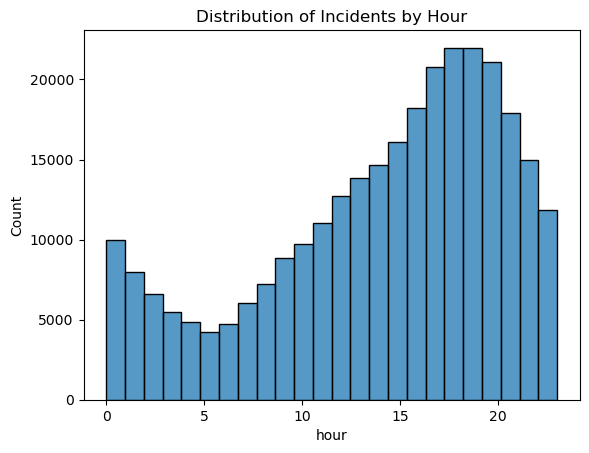

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


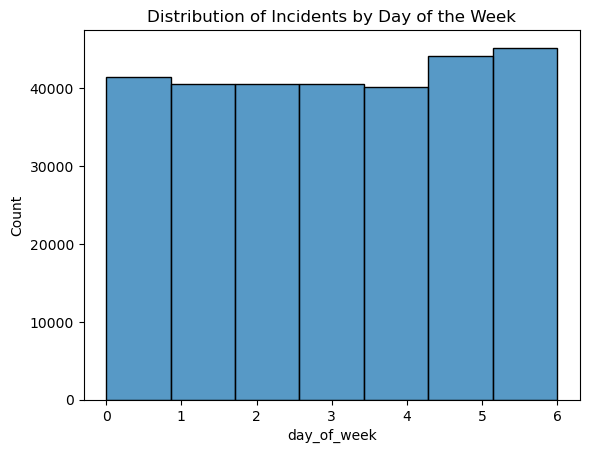

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


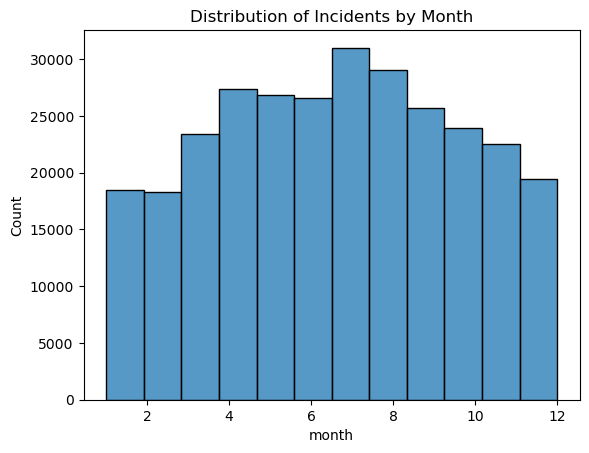

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

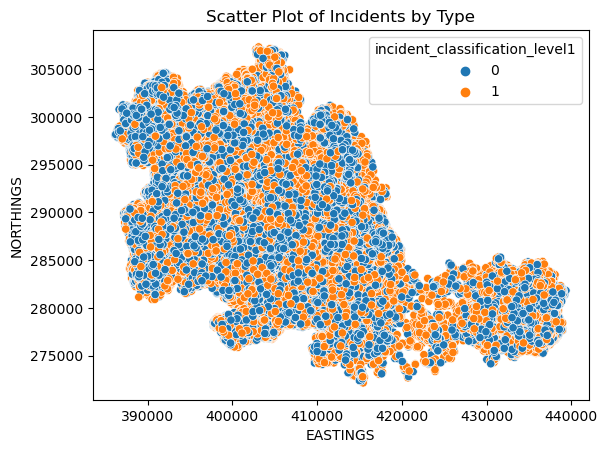

In [13]:
# Distribution of incidents by hour
sns.histplot(incidents_df['hour'], bins=24)
plt.title('Distribution of Incidents by Hour')
plt.show()

# Distribution by day of the week
sns.histplot(incidents_df['day_of_week'], bins=7)
plt.title('Distribution of Incidents by Day of the Week')
plt.show()

# Distribution by month
sns.histplot(incidents_df['month'], bins=12)
plt.title('Distribution of Incidents by Month')
plt.show()

# Scatter plot of incidents
sns.scatterplot(x='EASTINGS', y='NORTHINGS', hue='incident_classification_level1', data=incidents_df)
plt.title('Scatter Plot of Incidents by Type')
plt.show()


In [14]:
# Define features and target variable
features = ['hour', 'day_of_week', 'month']
X = incidents_df[features]
y = incidents_df['incident_classification_level1']

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
# Create a function to evaluate the models using the specified metrics
def evaluate_model(y_test, y_pred, y_prob):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_prob))

In [17]:
# Train a Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

# Predict and evaluate
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_probabilities = log_reg_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, log_reg_predictions, log_reg_probabilities)

Confusion Matrix:
[[16652 25400]
 [12383 33375]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47     42052
           1       0.57      0.73      0.64     45758

    accuracy                           0.57     87810
   macro avg       0.57      0.56      0.55     87810
weighted avg       0.57      0.57      0.56     87810

Precision: 0.5678434708634623
Recall: 0.7293806547488964
F1 Score: 0.6385543321247835
AUC-ROC: 0.5700853006782064


In [18]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, rf_predictions, rf_probabilities)

Confusion Matrix:
[[19737 22315]
 [14538 31220]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.47      0.52     42052
           1       0.58      0.68      0.63     45758

    accuracy                           0.58     87810
   macro avg       0.58      0.58      0.57     87810
weighted avg       0.58      0.58      0.58     87810

Precision: 0.5831698888577566
Recall: 0.682285064906683
F1 Score: 0.6288459408014663
AUC-ROC: 0.6034408176677865


In [19]:
# Train an XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
xgb_predictions = xgb_model.predict(X_test)
xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, xgb_predictions, xgb_probabilities)

Confusion Matrix:
[[19675 22377]
 [14263 31495]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.47      0.52     42052
           1       0.58      0.69      0.63     45758

    accuracy                           0.58     87810
   macro avg       0.58      0.58      0.58     87810
weighted avg       0.58      0.58      0.58     87810

Precision: 0.5846265221265221
Recall: 0.6882949429607937
F1 Score: 0.6322392853558164
AUC-ROC: 0.608391342916047


In [20]:
# Define the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Predict and evaluate
nn_probabilities = nn_model.predict(X_test).ravel()
nn_predictions = (nn_probabilities > 0.5).astype(int)
evaluate_model(y_test, nn_predictions, nn_probabilities)

Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20489/20489 ━━━━━━━━━━━━━━━━━━━━ 20s 927us/step - accuracy: 0.5637 - loss: 0.6830 - val_accuracy: 0.5788 - val_loss: 0.6781
Epoch 2/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 19s 923us/step - accuracy: 0.5742 - loss: 0.6791 - val_accuracy: 0.5815 - val_loss: 0.6766
Epoch 3/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 19s 946us/step - accuracy: 0.5797 - loss: 0.6767 - val_accuracy: 0.5822 - val_loss: 0.6757
Epoch 4/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 19s 944us/step - accuracy: 0.5800 - loss: 0.6754 - val_accuracy: 0.5838 - val_loss: 0.6748
Epoch 5/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 19s 949us/step - accuracy: 0.5830 - loss: 0.6748 - val_accuracy: 0.5826 - val_loss: 0.6753
Epoch 6/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 20s 977us/step - accuracy: 0.5809 - loss: 0.6751 - val_accuracy: 0.5844 - val_loss: 0.6747
Epoch 7/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 19s 930us/step - accuracy: 0.5821 - loss: 0.6751 - val_accuracy: 0.5847 - val_loss: 0.6755
Epoch 8/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 19s 932us/step - accur